# Example 4 - BPTT vs. RFLO

February 2022

The following notebook works through BPTT in various scenarios and RFLO in various scenarios:
* Training all weights `w_in`,`w_rec` and `w_out`
* Training each set of weights individually

And, specifically for RFLO, training online



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## Define network hyperparameters

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

In [5]:
params.print_params()

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7fc7735c6798>


# 1. Training with BPTT

We will see below that BPTT learns faster than RFLO, but both methods are capable of performing the center-out reach task with multiple targets

### 1a: BPTT, All Weights (`W_in`,`W_rec`,`W_out`)

11it [00:00, 109.49it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


500it [00:01, 385.29it/s]


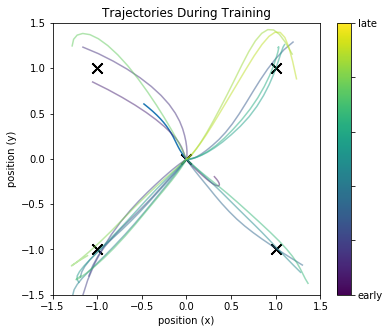

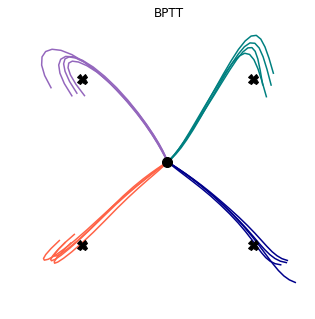

In [6]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_in','w_rec','w_out'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT')

### 1b: BPTT, `W_out` Only

12it [00:00, 117.69it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


500it [00:00, 506.44it/s]


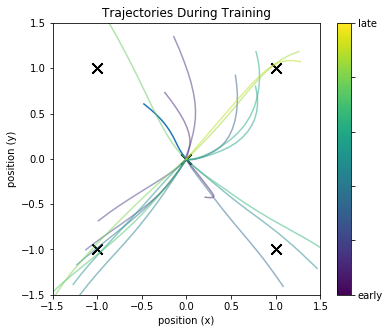

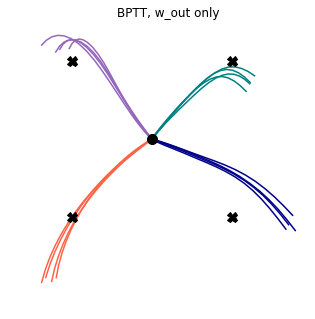

In [9]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_out'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_out only')

### 1c: BPTT, `W_rec` only

9it [00:00, 89.93it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


500it [00:01, 477.91it/s]


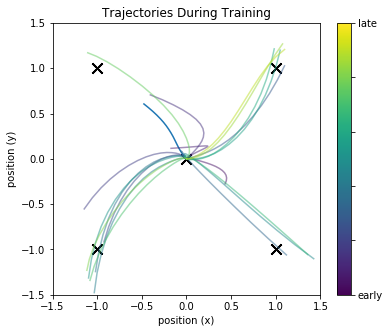

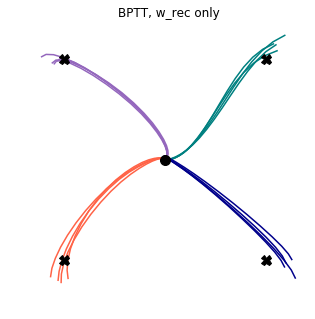

In [10]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_rec'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_rec only')

### 1d: BPTT, `W_in` only

12it [00:00, 114.81it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


500it [00:01, 365.31it/s]


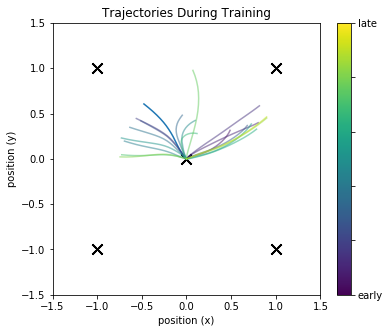

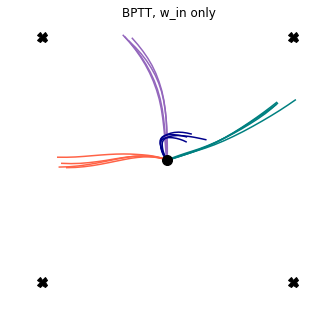

In [11]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algsorithm
bptt = BPTT(net,apply_to=['w_in'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_in only')

**Comments:** We see that the network performs well with noise when all sets of weights are trained, and pretty well when `w_rec` or `w_out` are trained alone. However, it is more difficult to perform the task when `w_in` is trained alone

# 2. Train with RFLO 

### 2a. RFLO, All Weights

9it [00:00, 87.00it/s]

apply_to :  ['w_in', 'w_rec', 'w_out']
online :  False
weight_transport :  True


500it [00:01, 319.29it/s]


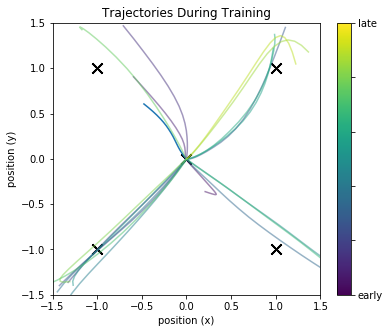

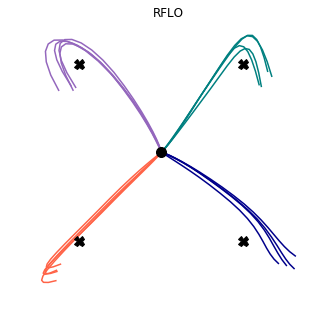

In [12]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_in','w_rec','w_out'],online=False,weight_transport=True) 
rflo.print_params()

sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO')


**Comments:** Note here that if we are training `w_out` we want `weight_transport=True` so that `w_m` is updated every time `w_out` is updated.

### 2b. RFLO, `W_rec` only

14it [00:00, 137.92it/s]

apply_to :  ['w_rec']
online :  False
weight_transport :  False


1000it [00:02, 452.55it/s]


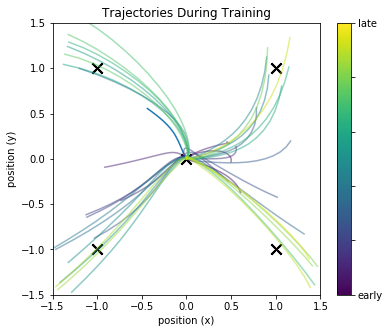

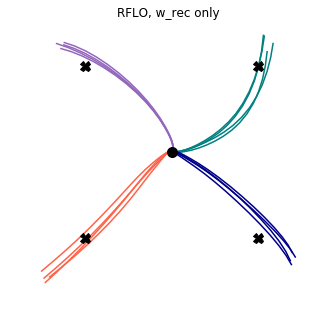

In [13]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, w_rec only')


**Comments:** Note here that if we are **not** training `w_out`, it does not matter whether `weight_transport=True` since `w_m` is initialize with the original (random) `w_out`

### 2c. RFLO, `W_in` only

4it [00:00, 39.80it/s]

apply_to :  ['w_in']
online :  False
weight_transport :  False


1000it [00:02, 489.63it/s]


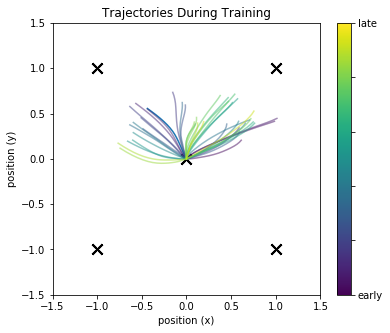

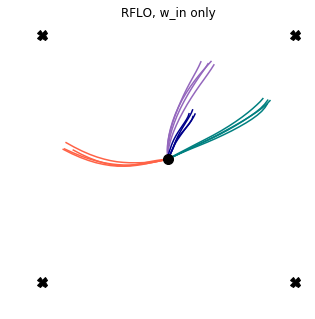

In [14]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_in'],online=False,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, w_in only')


### 2d. RFLO, Online learning, `apply_to=['w_rec','w_out']`,`weight_transport=False`

1it [00:00,  7.18it/s]

apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  False


500it [00:01, 343.93it/s]


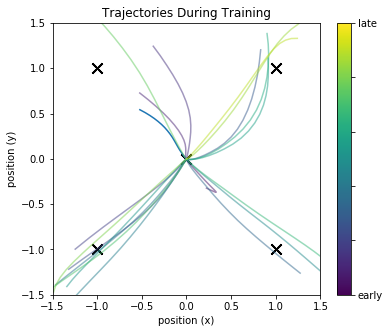

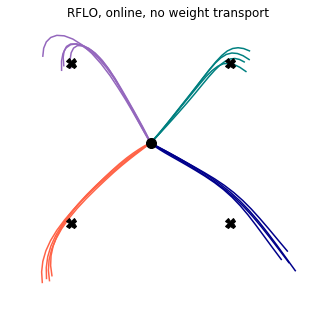

In [15]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, online, no weight transport')


**Comments:** Presumably this works even though `w_m` is not being set to `w_out`, due to the phenomenon of feedback alignment

### 2e. RFLO, Online learning, `apply_to=['w_rec','w_out']`,`weight_transport=True`

14it [00:00, 137.86it/s]

apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  True


500it [00:01, 384.78it/s]


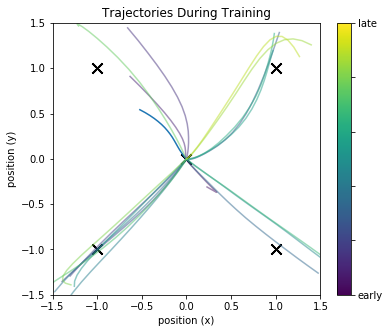

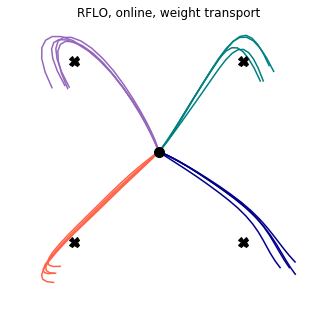

In [16]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True,weight_transport=True) 
rflo.print_params()

sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, online, weight transport')
